<font color=darkblue> 

## Описание задачи.
___
    
### Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
### Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды, основываясь на данных с параметрами добычи и очистки.
### Модель разрабатывается для оптимизации производства, чтобы не запускать предприятие с убыточными характеристиками.

## Описание данных.


### Технологический процесс:
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота
### Параметры этапов:
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи
### Наименование признаков:
Наименование признаков построено по принципу:
[этап].[тип_параметра].[название_параметра]
Пример: rougher.input.feed_ag
#### Значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики
### Значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Вызов бибиотек.

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# 1. Подготовка данных.

## 1.1 Открою данные и изучу их.

In [2]:
test = pd.read_csv('/datasets/gold_recovery_test.csv')
train = pd.read_csv('/datasets/gold_recovery_train.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
test.shape, train.shape, full.shape

((5856, 53), (16860, 87), (22716, 87))

### Проверю на пропуски.

In [4]:
def nan (df):
    df_na = pd.DataFrame(df.isna().sum())
    df_na['percent'] = df_na[0] * 100 / len(df)
    return df_na[(df_na['percent'] > 0)].sort_values('percent', ascending = False)[:7]
    

In [5]:
nan(test)

,0,percent
rougher.input.floatbank11_xanthate,353,6.028005
primary_cleaner.input.sulfate,302,5.157104
primary_cleaner.input.depressant,284,4.849727
rougher.input.floatbank10_sulfate,257,4.388661
primary_cleaner.input.xanthate,166,2.834699
rougher.input.floatbank10_xanthate,123,2.100410
rougher.input.feed_sol,67,1.144126


In [6]:
nan(train)

,0,percent
rougher.output.recovery,2573,15.260973
rougher.output.tail_ag,2250,13.345196
rougher.output.tail_au,2249,13.339265
rougher.output.tail_sol,2249,13.339265
secondary_cleaner.output.tail_sol,1986,11.779359
rougher.input.floatbank11_xanthate,1904,11.293001
final.output.recovery,1521,9.021352


In [7]:
nan(full)

,0,percent
rougher.output.recovery,3119,13.730410
rougher.output.tail_ag,2737,12.048776
rougher.output.tail_au,2736,12.044374
rougher.output.tail_sol,2736,12.044374
rougher.input.floatbank11_xanthate,2257,9.935728
secondary_cleaner.output.tail_sol,2215,9.750836
final.output.recovery,1963,8.641486


<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
удобный вывод) здорово

### 1.2. Проверю, что эффективность обогащения рассчитана правильно. Вычислю её на обучающей выборке для признака rougher.output.recovery. Найду MAE между расчётами и значением признака. 

In [8]:
def recovery(df):
    df = df.dropna().reset_index()
    C = df['rougher.output.concentrate_au'].dropna()
    F = df['rougher.input.feed_au'].dropna()
    T = df['rougher.output.tail_au'].dropna()
    recovery_calculated = ((C*(F-T)) / (F*(C-T)))*100
    rougher_output_recovery = df['rougher.output.recovery']
    MAE = mean_absolute_error(recovery_calculated, rougher_output_recovery)
    
    return(MAE, recovery_calculated, rougher_output_recovery)

In [9]:
MAE_recovery, recovery_calculated, rougher_output_recovery = recovery(train)

In [10]:
MAE_recovery

9.555596961987514e-15

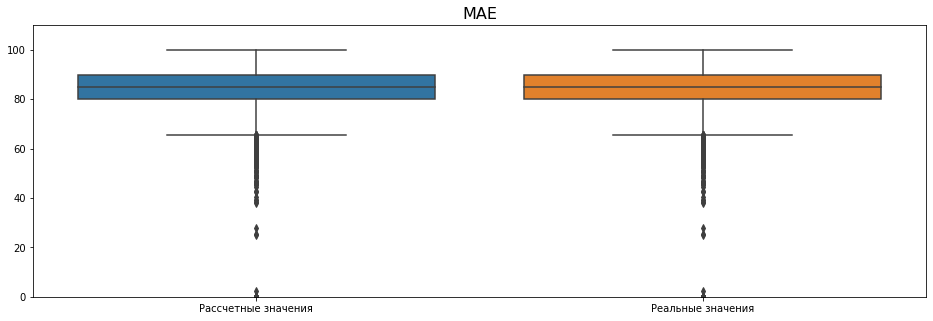

Реальные значения: 82.7418884610155
Рассчетные значения: 82.7418884610155


In [11]:
plt.figure(figsize=(16,5))
sns.boxplot(data=(recovery_calculated, rougher_output_recovery))
sns.set(style='white')
plt.title('MAE', fontsize=16)
plt.ylim(0, 110)
plt.xticks(np.arange(2), ('Рассчетные значения','Реальные значения'))
plt.show()


print('Реальные значения:', rougher_output_recovery .mean())
print('Рассчетные значения:', recovery_calculated.mean())

### Вывод

- Значение MAE меньше 9.55 при среднем в районе 85
- Графически полное совпадение
- Средние условно равны

#### Ошибка в расчете эффективности обогащения менее 10. 
#### C учетом графических данных, примем исходные данные условно-верными.

### 1.3. Проанализирую признаки, недоступные в тестовой выборке. Определю что это за параметры и к какому типу относятся.

In [12]:
count = 0
col_full = []
for i in train.columns:
    if i not in test.columns:
        count +=1
        col_full.append(i)
        print(i)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

In [13]:
print('Количество отсутствующих параметров -', count)

Количество отсутствующих параметров - 34


In [14]:
test.columns.tolist()

['date',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air'

### Вывод

- Недоступными для тестовой выборки оказалось 34 параметра.
- Как видно из наименований столбцов в тестовую выборку вошли только параметры сырья на флотацию и параметры технологического процесса на всех этапах.
- В обучающей выборке дополнительно представлены:
   - параметры концентрата после очистки;
   - рассчетные параметры для флуатационной установки;
   - параметры содержания металлов в хвостах.


### 1.4. Проведу предобработку данных.

In [15]:
test_precleaned = test
test_precleaned['date'] = pd.to_datetime(test_precleaned['date'])
test_precleaned.index = test_precleaned['date']

In [16]:
test_precleaned.between_time('06:59:59', '09:59:59')[3:8]

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 09:59:59,2016-09-01 09:59:59,126.961069,8.017856,7.03,0.805298,1400.816120,-499.014158,1399.975401,-499.570552,1401.871924,...,12.040725,-499.987743,7.989503,-499.750625,7.989710,-509.946737,5.068811,-499.293900,24.992741,-499.272255
2016-09-02 06:59:59,2016-09-02 06:59:59,NaN,NaN,7.16,NaN,412.629243,-795.316337,413.703253,-787.396567,441.604260,...,6.576244,-616.550019,4.625908,-678.347958,4.451592,-795.337422,3.544708,-800.024373,5.914889,-799.501783
2016-09-02 07:59:59,2016-09-02 07:59:59,5.039223,NaN,7.16,NaN,1436.850397,-542.923353,1549.140548,-528.601849,1548.664773,...,11.935144,-496.491878,7.967571,-527.714564,8.191769,-517.004063,4.906812,-531.125899,10.002271,-527.901468
2016-09-02 08:59:59,2016-09-02 08:59:59,0.857926,NaN,7.16,NaN,1435.627557,-499.752988,1550.871908,-500.348180,1513.760138,...,11.921123,-500.796461,7.988670,-501.212454,8.067387,-501.622580,5.067141,-499.295523,9.989370,-500.350093
2016-09-02 09:59:59,2016-09-02 09:59:59,24.616337,0.600245,7.16,0.196905,1437.685689,-498.718550,1549.223455,-498.417613,1510.244855,...,12.002664,-499.113047,8.061677,-495.442389,8.079009,-495.166033,5.171338,-479.361256,10.056638,-498.991980


In [17]:
test = test.reset_index(drop = True)
test = test.reset_index(drop = True)

### Промежуточный Вывод

- В технологическом цикле существуют отрезки времени, когда объем подачи материала фиксирован, 
а значения подачи химии либо отсутствуют, либо нехарактерно низкие. Вероятно это ППР, очистка или конвейерный перерыв.
- При этом подача сульфатов может сохраняться в низких значениях, в то время как информация по остальным реагентам отсутствует.

#### Вероятно пропуски соответствуют нулевым значениям подачи.

#### Проверю теорию, убрав низкие значения сульфатов:

### Тестовая выборка

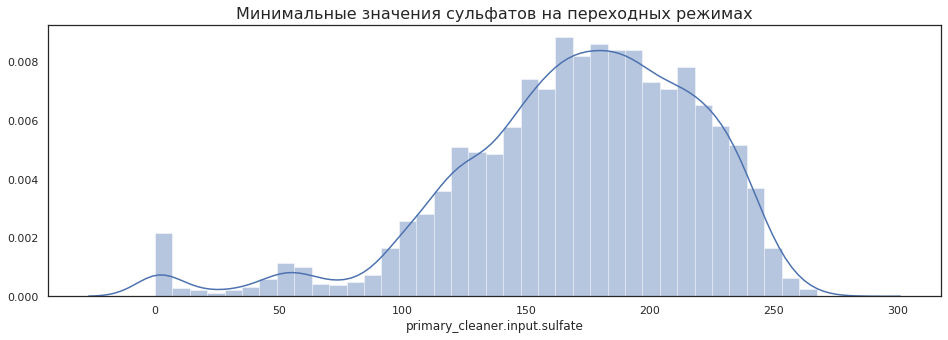

count    5554.000000
mean      170.515243
std        49.608602
min         0.000103
25%       143.340022
50%       176.103893
75%       207.240761
max       274.409626
Name: primary_cleaner.input.sulfate, dtype: float64


In [18]:
k = test['primary_cleaner.input.sulfate'].dropna()
plt.figure(figsize=(16,5))
sns.distplot(k)
sns.set(style='white')
plt.title('Минимальные значения сульфатов на переходных режимах', fontsize=16)
plt.show()
print(k.describe())

In [19]:
test_precleaned = test[test['primary_cleaner.input.sulfate'] > 90]
nan (test_precleaned)

,0,percent
rougher.input.feed_sol,10,0.190658
secondary_cleaner.state.floatbank3_a_air,6,0.114395
secondary_cleaner.state.floatbank2_a_air,3,0.057197
primary_cleaner.input.depressant,2,0.038132
rougher.input.feed_rate,1,0.019066
rougher.input.floatbank10_sulfate,1,0.019066
rougher.input.floatbank11_xanthate,1,0.019066


### Теория о нулевых значениях похоже верна,  дропну пропуски и нулевые  значения через нулевые значения recovery, coберу тестовую выборку.

In [20]:
full['date'] = pd.to_datetime(full['date'])
full_recovery = full[['date','rougher.output.recovery', 'final.output.recovery']]

In [21]:
test_cleaned = test.merge(full_recovery, on='date', how='left')
#test_cleaned = test_cleaned[test_cleaned['primary_cleaner.input.sulfate'] > 0]
nan(test_cleaned)

,0,percent
rougher.output.recovery,546,9.323770
final.output.recovery,442,7.547814
rougher.input.floatbank11_xanthate,353,6.028005
primary_cleaner.input.sulfate,302,5.157104
primary_cleaner.input.depressant,284,4.849727
rougher.input.floatbank10_sulfate,257,4.388661
primary_cleaner.input.xanthate,166,2.834699


In [22]:
test_cleaned = test_cleaned.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
nan(test_cleaned)

,0,percent
rougher.input.floatbank11_xanthate,25,0.472590
rougher.input.feed_sol,21,0.396975
secondary_cleaner.state.floatbank3_a_air,9,0.170132
rougher.input.floatbank11_sulfate,8,0.151229
primary_cleaner.input.depressant,5,0.094518
rougher.input.floatbank10_sulfate,5,0.094518
primary_cleaner.input.sulfate,4,0.075614


In [23]:
test_cleaned = test_cleaned.dropna().reset_index(drop=True)
test_cleaned = test_cleaned[(test_cleaned['rougher.output.recovery'] != 0) &
                            (test_cleaned['final.output.recovery'] != 0)]

In [24]:
test_cleaned.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
count,5105.000000,5105.000000,5105.000000,5105.000000,5105.000000,5105.000000,5105.000000,5105.000000,5105.000000,5105.000000,...,5.105000e+03,5105.000000,5105.000000,5105.000000,5105.000000,5105.000000,5105.000000,5105.000000,5105.000000,5105.000000
mean,176.436985,8.692184,7.266733,1.397742,1543.061702,-497.751664,1549.232616,-499.775558,1532.319704,-498.402197,...,1.382773e+01,-463.526653,12.901717,-500.711541,9.989147,-495.184784,17.420905,-501.180209,86.772032,69.161680
std,41.480857,3.017628,0.602686,0.635319,108.322102,18.216067,115.089399,29.319501,114.921977,20.330350,...,3.319874e+00,82.320796,2.992253,14.948015,2.806506,33.062771,4.505128,37.892051,5.494631,7.207293
min,17.886900,0.113356,5.650000,0.026293,1011.533202,-783.448551,1012.933963,-799.754942,212.035417,-786.260257,...,2.489718e-17,-799.868171,6.032592,-729.475816,2.781642,-614.076055,0.127304,-809.741464,10.430587,2.030917
25%,148.685271,6.491017,6.900000,0.932579,1499.312387,-500.352456,1499.282228,-500.698424,1484.683655,-501.016906,...,1.208219e+01,-500.304036,10.926903,-500.700592,8.069700,-500.191063,14.003135,-500.680453,84.837902,65.866591
50%,179.139848,8.050866,7.250000,1.200587,1591.469085,-499.971252,1596.465857,-500.028555,1550.223632,-500.022076,...,1.496892e+01,-499.572304,12.973464,-499.983203,10.014514,-499.989429,16.019971,-500.001374,87.501382,70.001868
75%,208.751220,10.021564,7.590000,1.804552,1602.192498,-499.577361,1602.470070,-499.294431,1601.326123,-499.005700,...,1.596784e+01,-400.930898,15.249457,-499.289757,12.000132,-499.722268,21.035080,-499.372917,89.806426,73.339433
max,265.983123,20.046764,15.500000,4.102454,1810.767191,-57.195404,1813.083671,-142.527229,1715.053773,-150.937035,...,2.031998e+01,-110.550392,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487,99.169699,100.000000


### Обучающая выборка.

In [25]:
train_cleaned = train[test_cleaned.columns.tolist()]

train_cleaned = train_cleaned.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
train_cleaned = train_cleaned[train_cleaned['primary_cleaner.input.sulfate'] > 0 &
                             (train_cleaned['rougher.output.recovery'] != 0) &
                            (train_cleaned['final.output.recovery'] != 0)].reset_index(drop=True)

In [26]:
nan(train_cleaned)

,0,percent
rougher.state.floatbank10_e_air,435,3.078774
rougher.input.floatbank11_xanthate,412,2.915988
secondary_cleaner.state.floatbank2_a_air,216,1.528771
rougher.input.feed_size,143,1.012103
rougher.input.feed_pb,100,0.707764
primary_cleaner.input.xanthate,88,0.622832
rougher.input.feed_sol,65,0.460047


In [27]:
train_cleaned = train_cleaned.fillna(method='ffill')

# 2. Анализ данных.

## 2.1. Посмотрю, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишу выводы.

In [28]:
def concentration (item, name, f, s):
    concentrate = full.columns[full.columns.str.contains(item)]

    plt.figure(figsize=(15,6))
    sns.boxplot(data=full[concentrate[[2,1,0]]])
    sns.set(style='white')
    plt.title(name, fontsize=16)
    plt.ylim(f, s)
    plt.xlabel('Этапы очистки', labelpad=10, fontsize=16)
    plt.ylabel('Концентрация', labelpad=15, fontsize=16)
    plt.xticks(np.arange(3), ('Флотация','Первичная очистка','Вторичная очистка'))
    plt.show()
    
    print('Флотация:','        ', full[concentrate[2]].mean())
    print('Первичная очистка:', full[concentrate[1]].mean())
    print('Вторичная очистка:', full[concentrate[0]].mean())

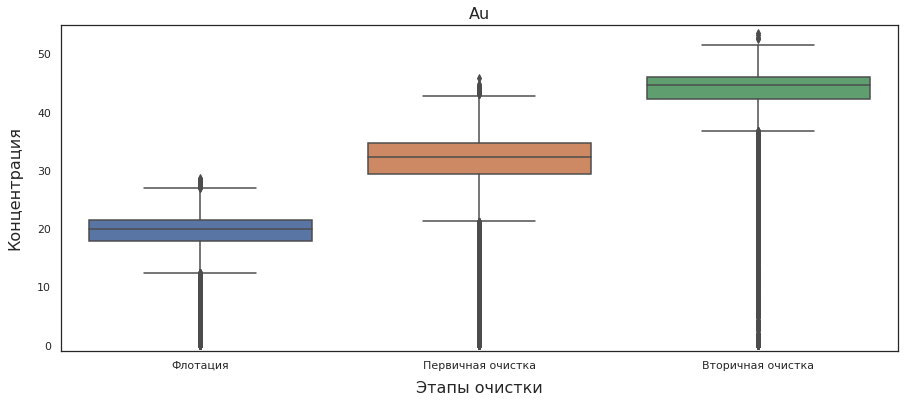

Флотация:          17.879538203033484
Первичная очистка: 29.2122887022116
Вторичная очистка: 40.001171896007136


In [29]:
concentration ('concentrate_au', 'Au', -1, 55)

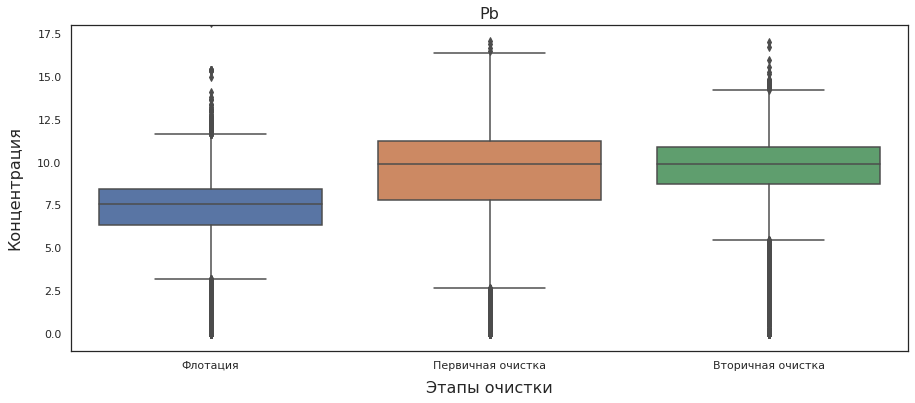

Флотация:          6.900646225251443
Первичная очистка: 8.921109840609049
Вторичная очистка: 9.095308105450266


In [30]:
concentration ('concentrate_pb', 'Pb', -1, 18)

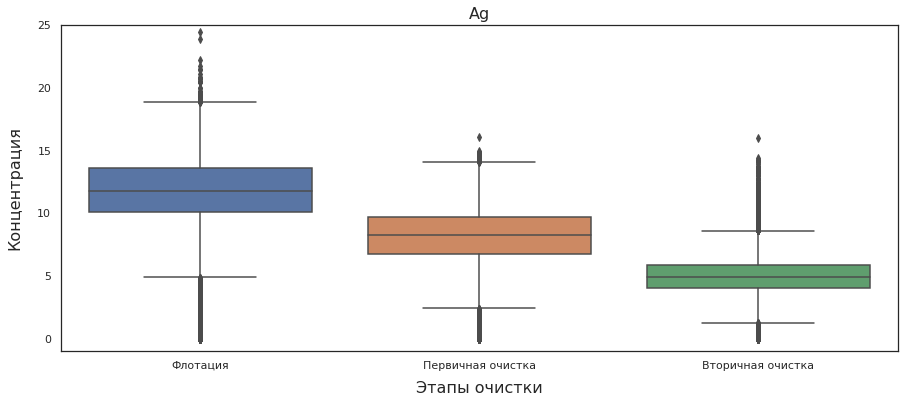

Флотация:          10.874483745395448
Первичная очистка: 7.69165176429709
Вторичная очистка: 4.781559451695084


In [31]:
concentration ('concentrate_ag', 'Ag', -1, 25)

## Вывод

- Концентрация золота и свинца растет видимо из-за близких атомарных масс
- Концентрация серебра падает вероятно из-за ионной активности


### 2.2. Сравню распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [32]:
def fraction (df,  name):
    plt.figure(figsize=(16,5))
    sns.rugplot(df)
    sns.kdeplot(df)
    sns.set(style='white')
    plt.title(name, fontsize=16)
    plt.xlim(20, 140)
    plt.ylabel('Фракция', labelpad=15, fontsize=14)
    plt.show()

    print(name, 'среднее:', df.mean())
    print(name, 'медиана:', df.median())

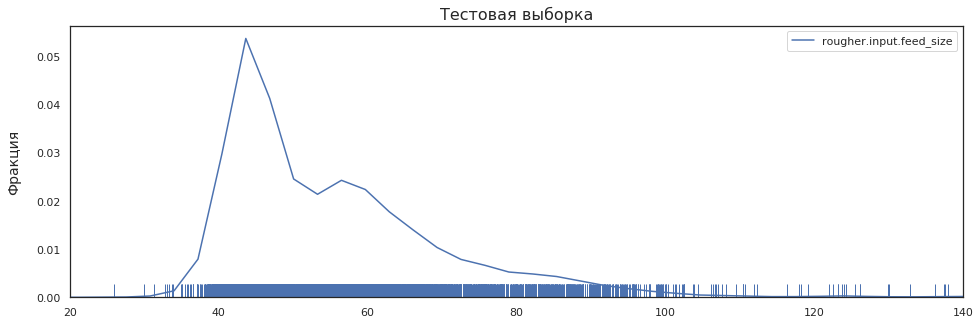

Тестовая выборка среднее: 55.917370684651154
Тестовая выборка медиана: 51.03322560308957


In [33]:
fraction(test_cleaned['rougher.input.feed_size'], 'Тестовая выборка')

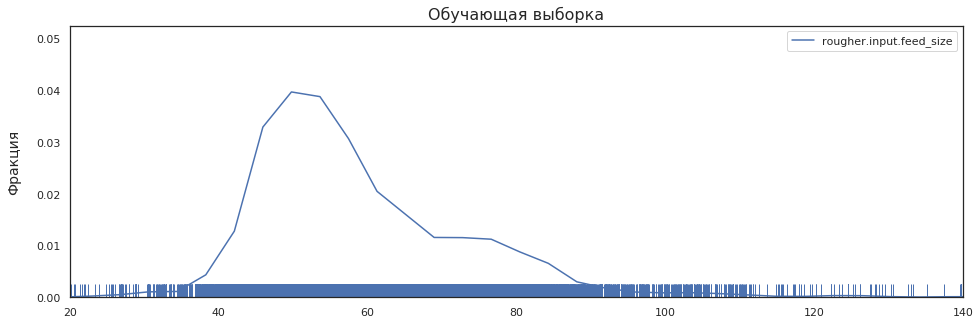

Обучающая выборка среднее: 60.260784027260215
Обучающая выборка медиана: 55.2778792103774


In [34]:
fraction(train_cleaned['rougher.input.feed_size'], 'Обучающая выборка')

## Вывод

- За внешней непохожестью скрываются близкие цифры среднего и медианы.
- Если обратить внимание на линейный график, то можно заметить что тестовая выборка является сильно апроксимированной обучающей.
- Плотность распределения близка.
- Ошибка в обучении возможна.

### 2.3. Исследую суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Проверю аномальные значения в суммарном распределении. Если они есть, проверю стоит ли их удалять из обеих выборок.

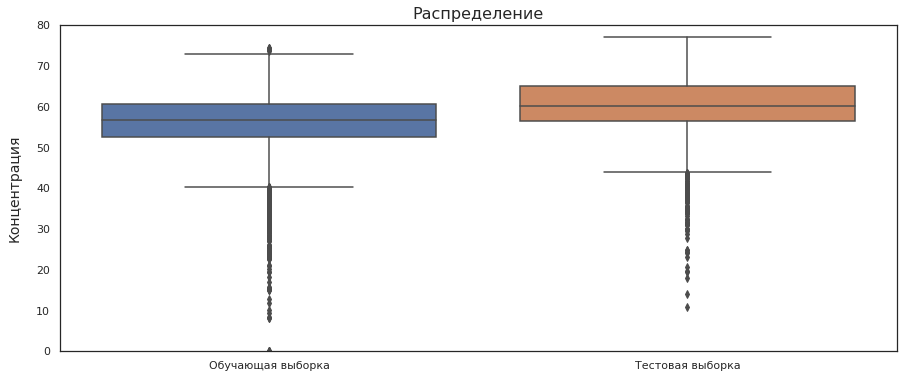

Обучающая выборка: 56.25151546878152
Тестовая выборка: 60.33475705324066


In [35]:
concentrate_train = train_cleaned.columns[train_cleaned.columns.str.contains('feed_ag|feed_au|feed_pb|feed_sol')]
train_cleaned['summ'] = train_cleaned[concentrate_train].sum(axis=1)
concentrate_test = test_cleaned.columns[test_cleaned.columns.str.contains('feed_ag|feed_au|feed_pb|feed_sol')]
test_cleaned['summ'] = test_cleaned[concentrate_train].sum(axis=1)

plt.figure(figsize=(15,6))
sns.boxplot(data=(train_cleaned['summ'], test_cleaned['summ']))
sns.set(style='white')
plt.title('Распределение', fontsize=16)
plt.ylim(0, 80)
plt.ylabel('Концентрация', labelpad=15, fontsize=14)
plt.xticks(np.arange(2), ('Обучающая выборка','Тестовая выборка'))
plt.show()


print('Обучающая выборка:', train_cleaned['summ'].mean())
print('Тестовая выборка:', test_cleaned['summ'].mean())

In [36]:
def summ (df):
    concentrate_feed = df.columns[df.columns.str.contains('feed_ag|feed_au|feed_pb|feed_sol')]
    df['summ_feed'] = df[concentrate_feed].sum(axis=1)
    
    concentrate_rougher = df.columns[df.columns.str.contains('rougher.output.concentrate')]
    df['summ_rougher'] = df[concentrate_rougher].sum(axis=1)
    
    concentrate_final = df.columns[df.columns.str.contains('final.output.concentrate')]
    df['summ_final'] = df[concentrate_final].sum(axis=1)
    
    plt.figure(figsize=(15,6))
    sns.boxplot(data=df[['summ_feed', 'summ_rougher', 'summ_final']])

    sns.set(style='white')
    plt.title('Распределение', fontsize=16)
    plt.ylim(0, 100)
    plt.xlabel('Этапы очистки', labelpad=15, fontsize=14)
    plt.ylabel('Концентрация', labelpad=15, fontsize=14)
    plt.xticks(np.arange(3), ('Сырье','Флотация', 'Очистка'))
    plt.show()


    print('Сырье:', df['summ_feed'].mean())
    print('Флотация:', df['summ_rougher'].mean())
    print('Очистка:', df['summ_final'].mean())

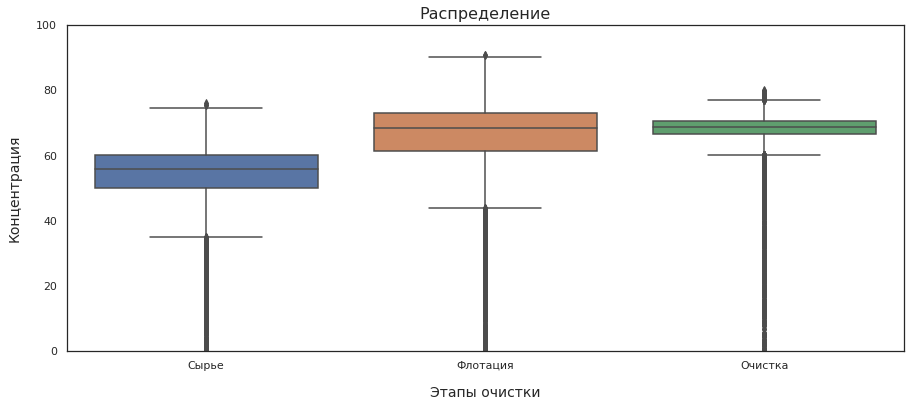

Сырье: 50.17649557418515
Флотация: 59.837826832897356
Очистка: 61.19136974862701


In [37]:
summ(train)

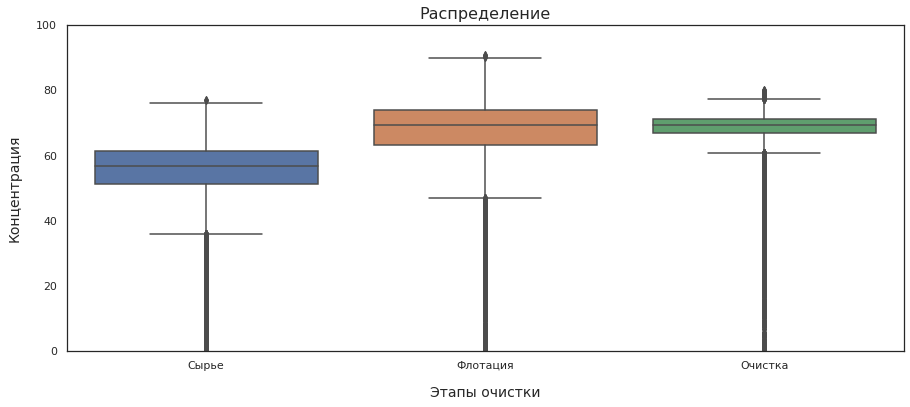

Сырье: 51.58407933883095
Флотация: 61.37809044184742
Очистка: 62.166909548565165


In [38]:
summ(full)

## Вывод

- На стадии флотации поднимается общая концентрация
- На стадии очистки остается золото (соответственно мы видим сужение диапазона и незначительный рост концентрапции, который на самом деле будет значительным для элемента AU)



In [39]:
def hist (df):
    concentrate_feed = df.columns[df.columns.str.contains('feed_ag|feed_au|feed_pb|feed_sol')]
    df['summ_feed'] = df[concentrate_feed].sum(axis=1)

    plt.figure(figsize=(16,5))
    sns.distplot(df['summ_feed'])
    sns.set(style='white')
    plt.title('Концентрации веществ', fontsize=16)
    plt.show()

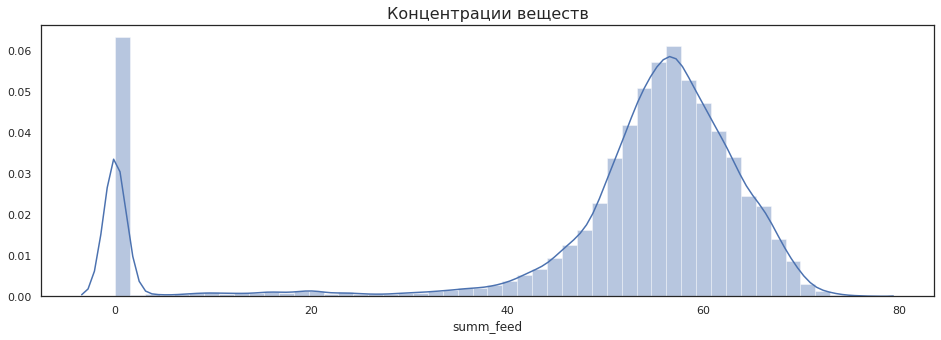

In [40]:
hist(train)

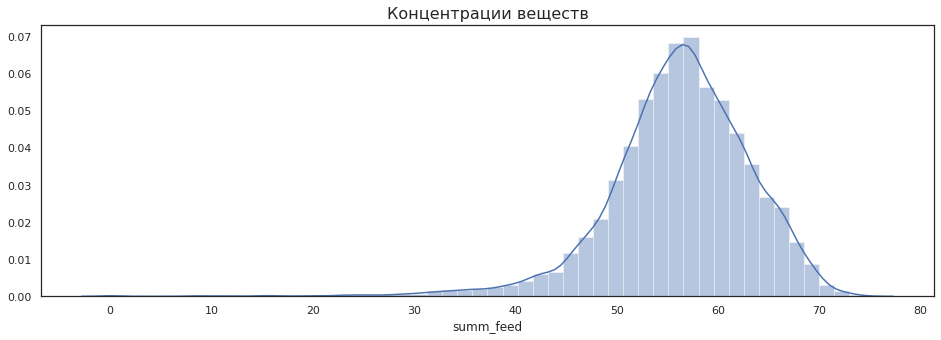

In [41]:
hist(train_cleaned)

In [42]:
train_cleaned = train_cleaned.drop('summ_feed', axis = 1)

# 3. Построение модели.

## Функция для вычисления итоговой sMAPE

In [43]:
def smape(targets, predictions):
    array = (abs(np.array(targets) - predictions) 
              / 
             ((abs(np.array(targets)) + abs(predictions)) / 2) * 100
             )
    smape_of_two = np.sum(array,axis=0)
    smape_rougher = smape_of_two[1] / len(array)
    smape_final = smape_of_two[0] / len(array)
    final_sMAPE = (0.25 * smape_rougher) + (0.75 * smape_final)
    return final_sMAPE

### Дата теперь не к чему

In [44]:
train_cleaned = train_cleaned.drop(['date', 'summ'], axis = 1)
test_cleaned = test_cleaned.drop(['date', 'summ'], axis = 1)

### Разделю признаки

In [45]:
target_train = train_cleaned[['rougher.output.recovery', 'final.output.recovery']]
features_train = train_cleaned.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)
target_test = test_cleaned[['rougher.output.recovery', 'final.output.recovery']]
features_test = test_cleaned.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)

### Метрика кросс валидации

In [46]:
def validation(model, features, target):
    score = make_scorer(smape)
    l_score = cross_val_score(model, features, target, cv=5, scoring=score)
    return l_score.mean()

### Линейная регрессия

In [47]:
linear = LinearRegression().fit(features_train, target_train)
validation(linear, features_train, target_train)

12.691873761872767

In [48]:
prediction_linear = linear.predict(features_test)
print('SMAPE:', smape(target_test, prediction_linear))

SMAPE: 6.569389674383538


### Случайный лес

In [49]:
#score = make_scorer(smape)
#for depth in range(3, 16, 2):
    #for estim in range(4, 101, 10):
        #forest_regressor = RandomForestRegressor(random_state=42, max_depth=depth, n_estimators=estim)
        #smape_score = cross_val_score(forest_regressor, features_train, target_train, cv=5, scoring=score)
        
        #print('max_depth=', depth, ',', "n_estimators =", estim, " -- ", end='')
        #print('smape_score:', smape_score.mean())

In [50]:
forest = RandomForestRegressor(n_estimators=76, max_depth=5, random_state=42)
smape_score = cross_val_score(forest, features_train, target_train, cv=5, scoring=make_scorer(smape))
smape_score.mean()

10.723405005985972

In [51]:
forest.fit(features_train, target_train)
prediction_forest = forest.predict(features_test)
print('SMAPE:', smape(target_test, prediction_forest))

SMAPE: 5.6377480205325


### Lasso

In [52]:
Lasso = Lasso(alpha=0.2)
smape_score = cross_val_score(Lasso, features_train, target_train, cv=5, scoring=make_scorer(smape))
smape_score.mean()

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1060.957923492184, tolerance: 121.37149806257378
  positive)


11.789448855962267

In [53]:
Lasso = Lasso.fit(features_train, target_train)
prediction_lasso = Lasso.predict(features_test)
print('SMAPE:', smape(target_test, prediction_lasso))

SMAPE: 6.564855654803981


## Проверка на адекватность

In [54]:
dummy_regr = DummyRegressor(strategy="mean").fit(features_train, target_train)
predictions_dummy = dummy_regr.predict(features_test)


In [55]:
SMAPE_DUMMY = pd.DataFrame(data={'Model': ['Dummy', 'Линейная регрессия', 'Случайный лес','Lasso'], 
                   'Score': [round(smape(target_test, predictions_dummy),2),
                             round(smape(target_test, prediction_linear),2),
                             round(smape(target_test, prediction_forest),2),
                             round(smape(target_test, prediction_lasso),2)]}).sort_values('Score')

In [56]:
SMAPE_DUMMY

,Model,Score
2,Случайный лес,5.64
3,Lasso,6.56
1,Линейная регрессия,6.57
0,Dummy,7.16


In [57]:
target_constant = target_test[['rougher.output.recovery','final.output.recovery']]
target_constant['rougher.output.recovery'] = target_train['rougher.output.recovery'].median()
target_constant['final.output.recovery'] = target_train['final.output.recovery'].median()

In [58]:
SMAPE_CONSTANT = pd.DataFrame(data={'Model': ['Константа','Линейная регрессия', 'Случайный лес','Lasso'], 
                   'Score': [round(smape(target_test, target_constant),2),
                             round(smape(target_test, prediction_linear),2),
                             round(smape(target_test, prediction_forest),2),
                             round(smape(target_test, prediction_lasso),2)]}).sort_values('Score')

In [59]:
SMAPE_CONSTANT

,Model,Score
2,Случайный лес,5.64
0,Константа,5.66
3,Lasso,6.56
1,Линейная регрессия,6.57


# Вывод: 
# - Лучший smape на тестовой выборке по среднему показывает модель Cлучайного леса.
# - Единственно возможный скор для принятия модели по медиане показывает модель Случайного леса.